In [78]:
import pandas as pd
import plotly.express as px

# Load dataset and treat first column as index
data = pd.read_csv("./demand_inventory.csv", index_col=0)

# Check the first few rows
print(data.head())


         Date Product_ID  Demand  Inventory
0                                          
0  01-06-1982         P1      63       5500
1  02-06-1982         P1      73       5437
2  03-06-1982         P1      82       5376
3  04-06-1982         P1      86       5226
4  05-06-1982         P1      68       5050


In [79]:
# Plot demand
fig_demand = px.line(data, x='Date',
                     y='Demand',
                     title='Demand Over Time')
fig_demand.show()

In [80]:
# Prepare time series
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [81]:
data['Date'] = pd.to_datetime(data['Date'], format='%d-%m-%Y')
time_series = data.set_index('Date')['Demand']

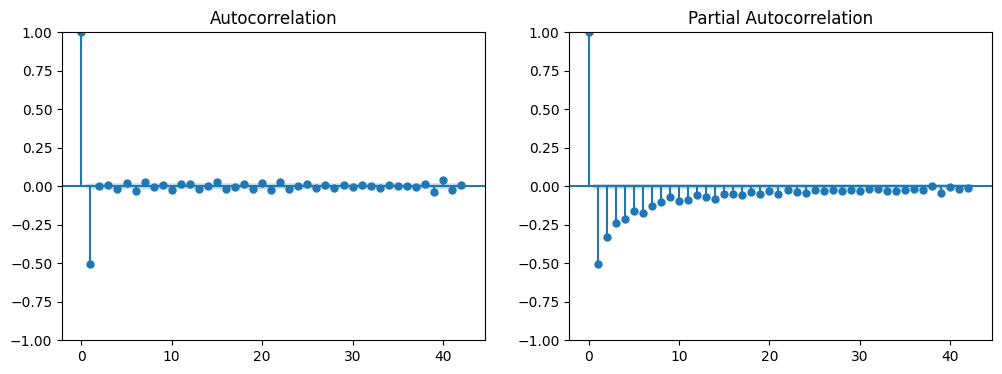

In [82]:
# Differencing check
differenced_series = time_series.diff().dropna()
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
plot_acf(differenced_series, ax=axes[0])
plot_pacf(differenced_series, ax=axes[1])
plt.show()

In [83]:
# SARIMAX Model
order = (1, 1, 1)
seasonal_order = (1, 1, 1, 2)
model = SARIMAX(time_series, order=order, seasonal_order=seasonal_order)
model_fit = model.fit(disp=False)

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



In [84]:
# Forecast
future_steps = 10
predictions = model_fit.predict(len(time_series), len(time_series) + future_steps - 1)
predictions = predictions.astype(int)
print("Forecasted Predictions:\n", predictions)

Forecasted Predictions:
 2025-01-01    133
2025-01-02    132
2025-01-03    132
2025-01-04    132
2025-01-05    132
2025-01-06    132
2025-01-07    132
2025-01-08    132
2025-01-09    132
2025-01-10    132
Freq: D, Name: predicted_mean, dtype: int64


In [85]:
# -------------------------------
# ✅ MODEL ACCURACY CHECK
# -------------------------------
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np


In [86]:
# Take last 'future_steps' points from actual data for testing
actual = time_series[-future_steps:]

In [87]:
# Align with predictions
pred_aligned = predictions[:len(actual)]

In [88]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Convert to numpy arrays
actual_arr = actual.to_numpy()
pred_arr = np.array(pred_aligned)

# Compute error metrics
mae = mean_absolute_error(actual_arr, pred_arr)
rmse = mean_squared_error(actual_arr, pred_arr) ** 0.5

# Handle zeros in actual safely
mask = actual_arr != 0
if mask.sum() > 0:
    mape = np.mean(np.abs((actual_arr[mask] - pred_arr[mask]) / actual_arr[mask])) * 100
    accuracy = 100 - mape
else:
    mape = np.nan
    accuracy = np.nan

print("MAE:", mae)
print("RMSE:", rmse)
print("MAPE:", mape, "%")
print("Model Accuracy:", accuracy, "%")


MAE: 20.5
RMSE: 24.357750306627253
MAPE: 17.41385441770065 %
Model Accuracy: 82.58614558229935 %


In [89]:
# -------------------------------
# INVENTORY OPTIMIZATION
# -------------------------------
future_dates = pd.date_range(start=time_series.index[-1] + pd.DateOffset(days=1),
                             periods=future_steps, freq='D')

forecasted_demand = pd.Series(predictions, index=future_dates)

initial_inventory = 5500
lead_time = 1
service_level = 0.95

z = np.abs(np.percentile(forecasted_demand, 100 * (1 - service_level)))
order_quantity = np.ceil(forecasted_demand.mean() + z).astype(int)
reorder_point = forecasted_demand.mean() * lead_time + z
safety_stock = reorder_point - forecasted_demand.mean() * lead_time

holding_cost = 0.1
stockout_cost = 10
total_holding_cost = holding_cost * (initial_inventory + 0.5 * order_quantity)
total_stockout_cost = stockout_cost * np.maximum(0, forecasted_demand.mean() * lead_time - initial_inventory)
total_cost = total_holding_cost + total_stockout_cost

print("Optimal Order Quantity:", order_quantity)
print("Reorder Point:", reorder_point)
print("Safety Stock:", safety_stock)
print("Total Cost:", total_cost)

Optimal Order Quantity: 265
Reorder Point: 264.1
Safety Stock: 132.00000000000003
Total Cost: 563.25
